In [162]:
import json
import ufl
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
#sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
#sys.path.append(os.environ.get('HIPPYFLOW_PATH',"../../"))
import hippyflow as hf

In [163]:
nx =1000 #
nodes = nx+1 # Number of nodal point
# Create an uniform interval grid of mesh points
mesh = dl.IntervalMesh(nx, dl.Constant(0.0), dl.Constant(1.0)) 
# Define Functional space for the state and parameter variable
degree = 2
Vh_STATE = dl.FunctionSpace(mesh, "CG", degree)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
# Creat a list of Spaces for State, parameter and adjoint
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]
k = 2 # Para
#print(mesh.coordinates())
coord = mesh.coordinates()
#print("coord\n", coord)
m_data = 1 + k * mesh.coordinates().copy()

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])

v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[0]", degree=2)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.inner(m*ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

targets = np.array([0.0, 0.05,0.15,0.25,0.35,0.45, 0.55,0.65, 0.75, 1.0])
#targets = coord
#print("targets",targets)
B = hp.assemblePointwiseObservation(Vh[hp.STATE], targets)
# I = hf.StateSpaceIdentityOperator(B, use_mass_matrix=True)
obs = hf.LinearStateObservable(pde, B)
m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

m_values = m_data.copy()
m.vector().set_local(m_values[d2v]) #uncomment this

x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)

u_data = x[hp.STATE].get_local()

obs_values = obs.evalu(x[hp.STATE])
obs_target = obs_values.get_local() 

J_obs = hf.ObservableJacobian(obs)
print(J_obs.shape)
J_obs.observable.setLinearizationPoint(x)
obs_target



(10, 1001)


/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/2174943560.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values[d2v]) #uncomment this


array([2.09999929e-23, 8.67550644e-02, 2.38814245e-01, 3.69070246e-01,
       4.82998649e-01, 5.84240585e-01, 6.75340475e-01, 7.58146556e-01,
       8.34043767e-01, 1.00000000e+00])

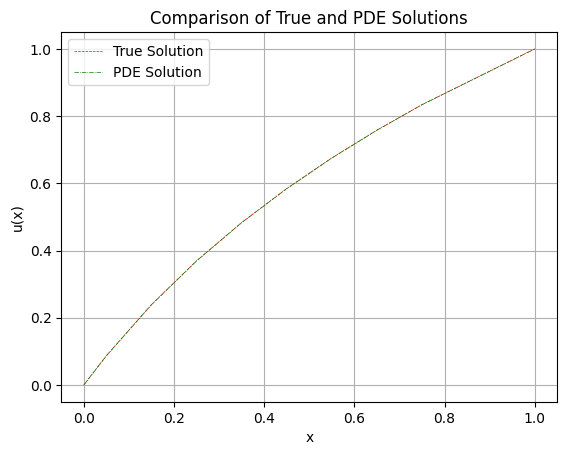

In [164]:
u_target_true = np.log(1 + k * targets)/np.log(1+k)
#print(u_target_true.shape, obs_target.shape )
#u_target_true.reshape(-1) - obs_target

plt.plot(targets, u_target_true, 'r--',linewidth=0.5, label='True Solution')   # red, dashed, circles
plt.plot(targets, obs_target, 'g-.',linewidth=0.5,label='PDE Solution')      # blue, solid, squares

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison of True and PDE Solutions")
plt.legend()
plt.grid(True)
plt.show()

In [165]:
dU_target = targets.shape[0]
dM = m.vector().get_local().shape[0]
Jm_obs_data = np.zeros((dU_target, dM))
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
Jhelp = dl.Vector()
for component in range(dM):
    m_hat = np.zeros((dM))
    m_hat[component] = 1
    m_nodes_hat.vector().set_local(m_hat) 
    
    J_obs.mult(m_nodes_hat.vector(), Jhelp) 
    Jm_obs_data[:,component] = Jhelp
Jm_obs_data

array([[-1.05209634e-20,  1.04790625e-20,  3.79260949e-26, ...,
         4.25913269e-27,  4.25345195e-27,  2.12483524e-27],
       [-8.30164662e-04, -1.65591575e-03, -1.64932504e-03, ...,
         1.75953074e-05,  1.75718391e-05,  8.77810856e-06],
       [-6.91938701e-04, -1.38019871e-03, -1.37470538e-03, ...,
         4.84353286e-05,  4.83707266e-05,  2.41638616e-05],
       ...,
       [-2.19851405e-04, -4.38533971e-04, -4.36788560e-04, ...,
         1.53764184e-04,  1.53559097e-04,  7.67112885e-05],
       [-1.50858761e-04, -3.00915482e-04, -2.99717808e-04, ...,
         1.69157346e-04,  1.68931728e-04,  8.43907706e-05],
       [-3.05598813e-20, -6.09572910e-20, -6.07146747e-20, ...,
        -6.81830956e-21, -2.24075908e-20,  1.12182592e-17]],
      shape=(10, 1001))

In [166]:
def test_jacobian(m_data_, obs_target_true,  J_true, epsilon):
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    dU = u.vector().get_local().shape[0]
    dM = m.vector().get_local().shape[0]
    error_total = 0
    error_div_u =0
    # print("J_true\n", J_true)
    for i in range(dM):
        m = dl.Function(Vh[hp.PARAMETER])
        u = dl.Function(Vh[hp.STATE])
        uadj = dl.Function(Vh[hp.ADJOINT])
        B = hp.assemblePointwiseObservation(Vh[hp.STATE], targets)
        obs = hf.LinearStateObservable(pde, B)
        
        m_values_ = m_data_.copy()
        m_values_[i] = m_values_[i] + epsilon
        m.vector().set_local(m_values_[d2v]) #uncomment this
        
        x = [u.vector(),m.vector(),uadj.vector()]
        pde.solveFwd(x[hp.STATE], x)

        u_data_current = x[hp.STATE].get_local()
        obs_values = obs.evalu(x[hp.STATE])
        obs_target_current = obs_values.get_local() 
        delta_u  = obs_target_current - obs_target_true
        error_div_u = error_div_u + np.linalg.norm(delta_u)
        #print(delta_u)
        Jm_FD_i = delta_u/epsilon
        # print(Jm_FD_i)
        error = np.linalg.norm(Jm_FD_i - J_true[:,i])
        error_total = error_total + error
    # error_total = np.linalg.norm(delta_u)
    return error_total ,error_div_u
        
        
    
epsilon_data = [1e-8, 1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#epsilon_data = [1e-8]
error_data =[]
error_div_u = []
for eps in epsilon_data:
    #test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    rms, err = test_jacobian(m_data_=m_data, obs_target_true=obs_target,  J_true=Jm_obs_data, epsilon=eps)
    error_data.append(rms)
    error_div_u.append(err)

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/4090107856.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values_[d2v]) #uncomment this


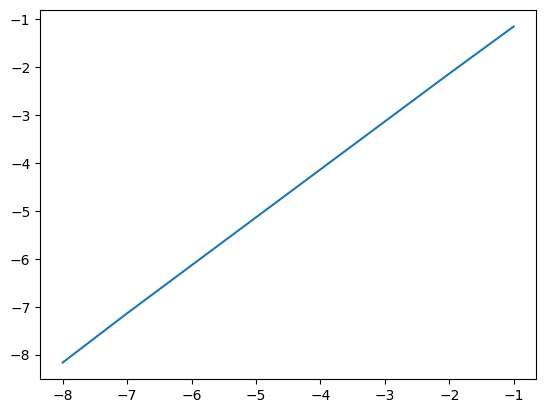

In [167]:
plt.plot(np.log10(epsilon_data), np.log10(error_div_u)) 

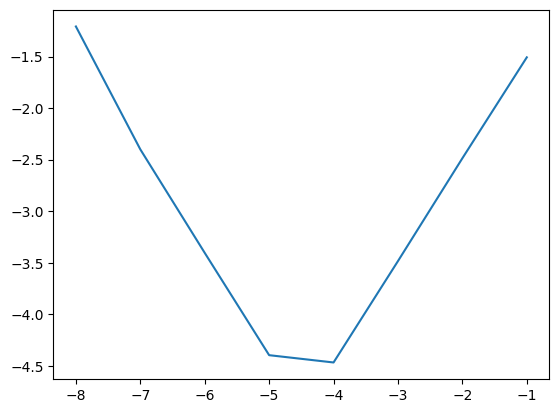

In [168]:
plt.plot(np.log10(epsilon_data), np.log10(error_data)) 

# We need to test with Jacobian w.r.t to k 
$$m = 1 + k x$$
$$R(u,m) = 0$$
$$\frac{du}{dk} = \frac{du}{dm} \frac{dm}{dk}$$

In [169]:

k = 2 # Para
#print(mesh.coordinates())
coord = mesh.coordinates()
#print("coord\n", coord)
m_data = 1 + k * mesh.coordinates().copy()
dm_dk = mesh.coordinates().copy()
#print("dm_dk\n", dm_dk)

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])

v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[0]", degree=2)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.inner(m*ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde2 = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

targets = np.array([0.0, 0.05,0.15,0.25,0.35,0.45, 0.55,0.65, 0.75, 1.0])
#targets = coord

B2 = hp.assemblePointwiseObservation(Vh[hp.STATE], targets)
# I = hf.StateSpaceIdentityOperator(B, use_mass_matrix=True)
obs2 = hf.LinearStateObservable(pde2, B2)
m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

m_values = m_data.copy()
m.vector().set_local(m_values[d2v]) #uncomment this

x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)

u_data = x[hp.STATE].get_local()

obs_values2 = obs2.evalu(x[hp.STATE])
obs_target2 = obs_values2.get_local() 

J_obs2 = hf.ObservableJacobian(obs2)
J_obs2.observable.setLinearizationPoint(x)

dU_target = targets.shape[0]
dM = m.vector().get_local().shape[0]
Jm_obs_data2 = np.zeros((dU_target))

m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
Jhelp2 = dl.Vector()
m_nodes_hat.vector().set_local(dm_dk)   
J_obs2.mult(m_nodes_hat.vector(), Jhelp2) 
Jm_obs_data2= Jhelp2.get_local()
Jm_obs_data2


/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/2933532361.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values[d2v]) #uncomment this
/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/2933532361.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_nodes_hat.vector().set_local(dm_dk)


array([1.46073485e-23, 1.50518894e-02, 3.25682385e-02, 3.97257992e-02,
       4.08540882e-02, 3.83167420e-02, 3.34888574e-02, 2.72099423e-02,
       2.00119835e-02, 4.59717583e-18])

In [170]:
def test_jacobian(k_data, obs_target_true,  J_true, epsilon):
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    
    error_total = 0
    error_div_u =0
   
    B = hp.assemblePointwiseObservation(Vh[hp.STATE], targets)
    obs = hf.LinearStateObservable(pde2, B)
    
    m_values_ = 1 + (k_data + epsilon) * mesh.coordinates().copy()
    m.vector().set_local(m_values_[d2v]) #uncomment this
    
    x = [u.vector(),m.vector(),uadj.vector()]
    pde.solveFwd(x[hp.STATE], x)
    # u_data = x[hp.STATE].get_local()
    obs_target_current = obs.evalu(x[hp.STATE]).get_local() 
 
    delta_u  = obs_target_current - obs_target_true
    error_div_u = error_div_u + np.linalg.norm(delta_u)
    #print(delta_u)
    Jm_FD_i = delta_u/epsilon
    # print(Jm_FD_i)
    error = np.linalg.norm(Jm_FD_i - J_true)
    error_total = error_total + error
    # error_total = np.linalg.norm(delta_u)
    return error_total ,error_div_u
        
        
    
epsilon_data = [1e-8, 1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#epsilon_data = [1e-8]
error_data =[]
error_div_u = []
for eps in epsilon_data:
    #test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    rms, err = test_jacobian(k_data=k, obs_target_true=obs_target2,  J_true=Jm_obs_data2, epsilon=eps)
    error_data.append(rms)
    error_div_u.append(err)

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/2377346483.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values_[d2v]) #uncomment this


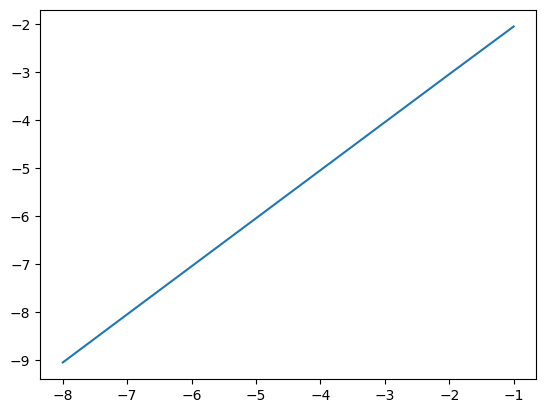

In [171]:
plt.plot(np.log10(epsilon_data), np.log10(error_div_u)) 

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/3722972882.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


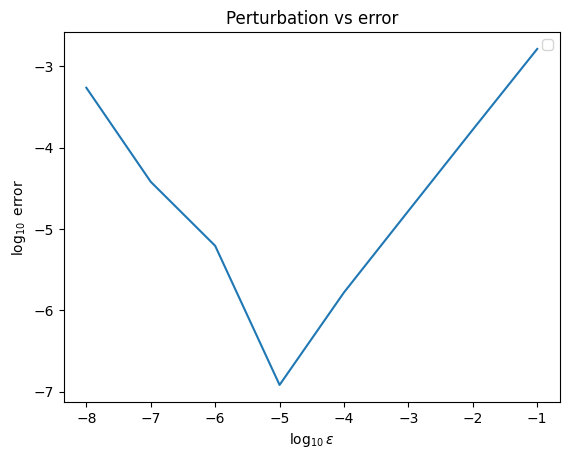

In [172]:
plt.plot(np.log10(epsilon_data), np.log10(error_data)) 
plt.xlabel("$\log_{10} \epsilon$")
plt.ylabel("$\log_{10}$ error")
plt.title("Perturbation vs error")
plt.legend()
plt.show()

# Trying to verify the result if the paramter of PDE, m is dependent on a vecotor input
$$m = k_1 + k_2 x$$

In [173]:

k = [1,2] # Para
#print(mesh.coordinates())
coord = mesh.coordinates()
#print("coord\n", coord)
m_data = k[0] + k[1] * mesh.coordinates().copy()
dm_dk = np.zeros((nodes, len(k)))
dm_dk[:,0]  = np.ones(nodes)
dm_dk[:,1]  = coord[:,0]
#print("dm_dk\n", dm_dk)

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])

v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

def u_boundary(x, on_boundary):
    return on_boundary and ( x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[0]", degree=2)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.inner(m*ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde3 = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

targets = np.array([0.0, 0.05,0.15,0.25,0.35,0.45, 0.55,0.65, 0.75, 1.0])
#targets = coord

B3 = hp.assemblePointwiseObservation(Vh[hp.STATE], targets)
# I = hf.StateSpaceIdentityOperator(B, use_mass_matrix=True)
obs3 = hf.LinearStateObservable(pde3, B3)
m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

m_values = m_data.copy()
m.vector().set_local(m_values[d2v]) #uncomment this

x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)

u_data = x[hp.STATE].get_local()

obs_values3 = obs2.evalu(x[hp.STATE])
obs_target3 = obs_values3.get_local() 

J_obs3 = hf.ObservableJacobian(obs3)
J_obs3.observable.setLinearizationPoint(x)

dU_target = targets.shape[0]
dK = len(k)
dM = m.vector().get_local().shape[0]
Jm_obs_data3 = np.zeros((dU_target, dK))
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
Jhelp3 = dl.Vector()
for component in range(dK):
    m_nodes_hat.vector().set_local(dm_dk[:,component])   
    J_obs3.mult(m_nodes_hat.vector(), Jhelp3) 
    Jm_obs_data3[:,component]= Jhelp3.get_local()
Jm_obs_data3.shape


/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/3927528404.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values[d2v]) #uncomment this


(10, 2)

In [174]:
def test_jacobian(k_data, obs_target_true,  J_true, epsilon):
    m = dl.Function(Vh[hp.PARAMETER])
    u = dl.Function(Vh[hp.STATE])
    uadj = dl.Function(Vh[hp.ADJOINT])
    
    error_total = 0
    error_div_u =0
   
    B = hp.assemblePointwiseObservation(Vh[hp.STATE], targets)
    obs = hf.LinearStateObservable(pde3, B)
    for i in range(len(k_data)):
        k_data_ = k_data.copy()
        k_data_[i] = k_data_[i] + epsilon
        m_values_ = k_data_[0] + k_data_[1] * mesh.coordinates().copy()
        m.vector().set_local(m_values_[d2v]) #uncomment this
        x = [u.vector(),m.vector(),uadj.vector()]
        pde.solveFwd(x[hp.STATE], x)
        # u_data = x[hp.STATE].get_local()
        obs_target_current = obs.evalu(x[hp.STATE]).get_local() 
    
        delta_u  = obs_target_current - obs_target_true
        error_div_u = error_div_u + np.linalg.norm(delta_u)
        #print(delta_u)
        Jm_FD_i = delta_u/epsilon
        # print(Jm_FD_i)
        error = np.linalg.norm(Jm_FD_i - J_true[:,i])
        error_total = error_total + error
    # error_total = np.linalg.norm(delta_u)
    return error_total ,error_div_u
        
        
    
epsilon_data = [1e-8, 1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#epsilon_data = [1e-8]
error_data =[]
error_div_u = []
for eps in epsilon_data:
    #test_jacobian(m_data_=m_data, u_true=u_pde,  J_true=Jm_data, epsilon=eps)
    rms, err = test_jacobian(k_data=k, obs_target_true=obs_target3,  J_true=Jm_obs_data3, epsilon=eps)
    error_data.append(rms)
    error_div_u.append(err)

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/4038413054.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m.vector().set_local(m_values_[d2v]) #uncomment this


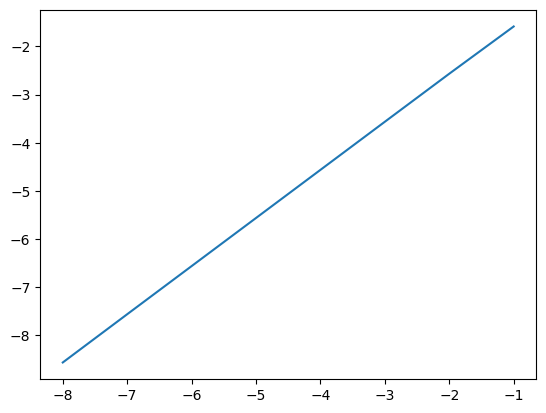

In [175]:
plt.plot(np.log10(epsilon_data), np.log10(error_div_u)) 

/var/folders/lr/h2867zhs72gcy61j6_cy0n0r0000gq/T/ipykernel_10565/3722972882.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


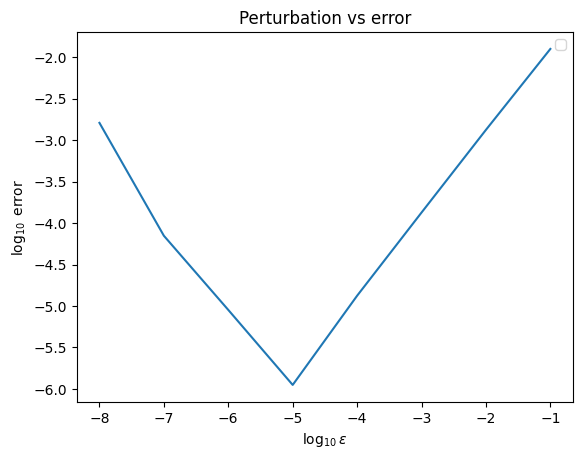

In [176]:
plt.plot(np.log10(epsilon_data), np.log10(error_data)) 
plt.xlabel("$\log_{10} \epsilon$")
plt.ylabel("$\log_{10}$ error")
plt.title("Perturbation vs error")
plt.legend()
plt.show()